In [4]:
import sys
import torch
sys.path.append('cocoapi\PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.CenterCrop(224),                             
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')
vocab_size = len(data_loader.dataset.vocab)

Vocabulary successfully loaded from vocab.pkl file!


In [5]:
from PIL import Image

def clean_sentence(output):
    sentence = ""
    for idx in output:
        if idx == 0:
            continue
        if idx == 1:
            break
        word = data_loader.dataset.vocab.idx2word[idx]
        sentence = sentence + word + ' '
        
    return sentence

def fetch_image(file_name):
    orig_image = Image.open(file_name).convert('RGB')
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    transform_test = transforms.Compose([ 
        transforms.Resize(256),                          
        transforms.CenterCrop(224),                             
        transforms.ToTensor(),                           
        transforms.Normalize((0.485, 0.456, 0.406),      
                             (0.229, 0.224, 0.225))])
    input_image = transform_test(orig_image)
    return orig_image, input_image

def generate_caption(input_image):
    print(input_image.shape)
    features = encoder(input_image).unsqueeze(1)
    features.to(device)
#     print(features.shape)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

In [7]:
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file_8_layers = 'comparitive_encoder_2-1.pkl'
decoder_file_8_layers = 'comparitive_decoder_2-1.pkl'

embed_size = 512
hidden_size = 512

encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

encoder.to(device)
decoder.to(device)

encoder.load_state_dict(torch.load(os.path.join(os.getcwd(),'models', encoder_file_8_layers)))
decoder.load_state_dict(torch.load(os.path.join(os.getcwd(),'models', decoder_file_8_layers)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
7 512


<All keys matched successfully>

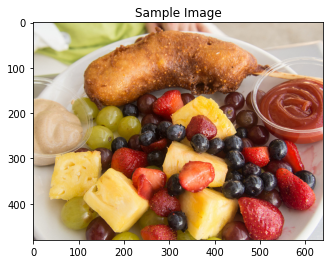

torch.Size([1, 3, 224, 224])
a plate of food with a sandwich and a salad . 


In [8]:
file_name = 'fruits.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)
generate_caption(input_image.reshape(1,3,224,224).to('cuda'))

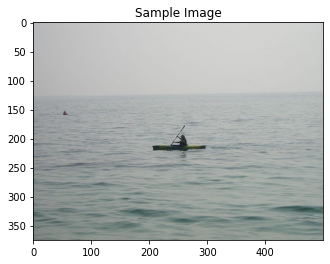

torch.Size([1, 3, 224, 224])
a man riding a wave on top of a surfboard . 


In [6]:
file_name = 'boat.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)
generate_caption(input_image.reshape(1,3,224,224).to('cuda'))

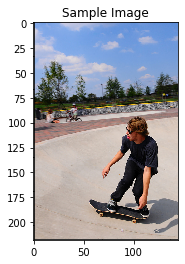

torch.Size([1, 3, 224, 224])
a man riding a skateboard down a street . 


In [5]:
file_name = 'skateboard.png'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)
generate_caption(input_image.reshape(1,3,224,224).to('cuda'))

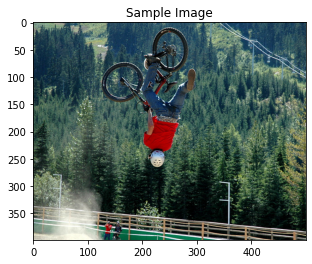

torch.Size([1, 3, 224, 224])
a large giraffe standing next to a tree . 


In [7]:
file_name = 'cycle.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)
generate_caption(input_image.reshape(1,3,224,224).to('cuda'))

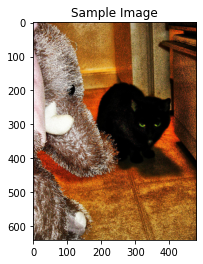

torch.Size([1, 3, 224, 224])
a cat is laying on a bed with a stuffed animal . 


In [43]:
file_name = 'cat.jpg'
address = os.path.join(os.getcwd(),'images',file_name)
orig_image, input_image = fetch_image(address)
generate_caption(input_image.reshape(1,3,224,224).to('cuda'))

In [44]:
import torch.nn.functional as F
from utils import visualize_cam, Normalize, print_examples
transform = transforms.Compose([
            transforms.Resize((356, 356)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
# features,image,orig_image = get_prediction()
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(orig_image)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.upsample(torch_img, size=(224, 224), mode='bilinear', align_corners=False)
norm_torch_img = normalizer(torch_img)

In [9]:
from gradcam import GradCAM
from datetime import datetime
from torchvision.utils import make_grid, save_image

In [45]:
from utils import find_resnet_layer
images = []

layer_name = encoder.resnet._modules['0']
model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
model_GradCAM = GradCAM(model_dict, True)
norm_torch_img.requires_grad = True
# print(norm_torch_img.requires_grad)
mask , logit = model_GradCAM(norm_torch_img)
mask = mask.cpu()
heatmap_t, result_t = visualize_cam(mask,torch_img)
images.append(torch.stack([torch_img.squeeze().cpu(),heatmap_t,result_t],0))

layer_name = encoder.resnet._modules['4'][0].conv1
model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
model_GradCAM = GradCAM(model_dict, True)
norm_torch_img.requires_grad = True
# print(norm_torch_img.requires_grad)
mask , logit = model_GradCAM(norm_torch_img)
mask = mask.cpu()
heatmap_t, result_t = visualize_cam(mask,torch_img)
images.append(torch.stack([torch_img.squeeze().cpu(),heatmap_t,result_t],0))

layer_name = encoder.resnet._modules['5'][0].conv1
model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
model_GradCAM = GradCAM(model_dict, True)
norm_torch_img.requires_grad = True
# print(norm_torch_img.requires_grad)
mask , logit = model_GradCAM(norm_torch_img)
mask = mask.cpu()
heatmap_t, result_t = visualize_cam(mask,torch_img)
images.append(torch.stack([torch_img.squeeze().cpu(),heatmap_t,result_t],0))

layer_name = encoder.resnet._modules['5'][7].conv3
model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
model_GradCAM = GradCAM(model_dict, True)
norm_torch_img.requires_grad = True
# print(norm_torch_img.requires_grad)
mask , logit = model_GradCAM(norm_torch_img)
mask = mask.cpu()
heatmap_t, result_t = visualize_cam(mask,torch_img)
images.append(torch.stack([torch_img.squeeze().cpu(),heatmap_t,result_t],0))

# layer_name = encoder.resnet._modules['6'][0].conv1
# model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
# model_GradCAM = GradCAM(model_dict, True)
# norm_torch_img.requires_grad = True
# # print(norm_torch_img.requires_grad)
# mask , logit = model_GradCAM(norm_torch_img)
# mask = mask.cpu()
# heatmap_t, result_t = visualize_cam(mask,torch_img)
# images.append(torch.stack([torch_img.squeeze().cpu(),heatmap_t,result_t],0))

# layer_name = encoder.resnet._modules['6'][35].conv3
# model_dict = dict(type='resnet',arch=encoder.resnet, layer_name=layer_name,input_size=(224,224))
# model_GradCAM = GradCAM(model_dict, True)
# norm_torch_img.requires_grad = True
# # print(norm_torch_img.requires_grad)
# mask , logit = model_GradCAM(norm_torch_img)
# mask = mask.cpu()
# heatmap_t, result_t = visualize_cam(mask,torch_img)
# images.append(torch.stack([torch_img.squeeze().cpu(),heatmap_t,result_t],0))


images = make_grid(torch.cat(images,0),nrow=3)

13_49_42


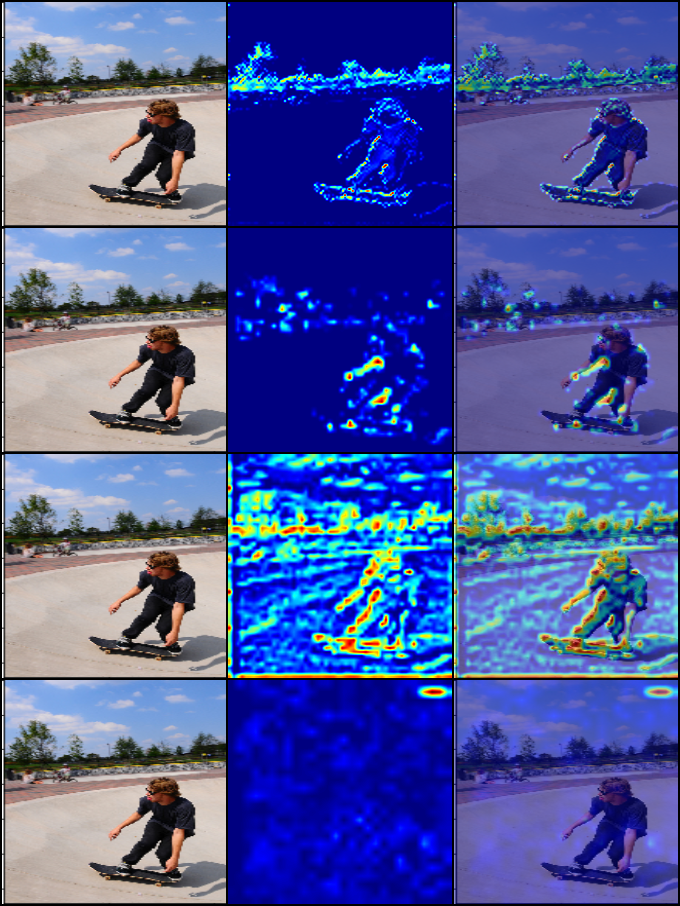

In [38]:
from datetime import datetime
now = datetime.now()
dt_string = now.strftime("%H_%M_%S")
print(dt_string)
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

output_name = dt_string+'_new_7_layers'+file_name
output_path = os.path.join(output_dir, output_name)

save_image(images, output_path)
Image.open(output_path)